# Generate Training Data for RNN

- Pad zeros in between each shot
    - Give it another class label?
- Add smooth transitions between shots
    - Shoot to next location?

### 1D Deterministic Data Generator

In [11]:
TIME_STEPS = 10
DECAY = .8
NUM_BETWEEN = 0

NUM_STARTS = 5
NUM_ENDS = 5

label
0    100
1    150
dtype: int64

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


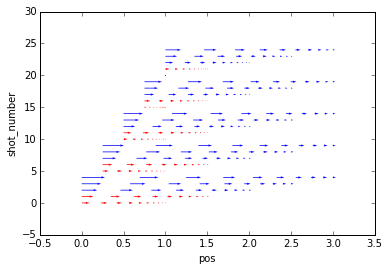

In [12]:
import math
import random

import itertools
from collections import namedtuple

State = namedtuple('State', ['shot_number', 'pos', 'vel', 'label'])
World = namedtuple('World', ['goal', 'end'])

def data_generator(num_starts=3, num_ends=5, time_steps=10, decay=.8, num_between=5):
    """Generate data from a fixed set of grid points
    
    Parameters
    ----------
    num_starts : int
    The number of starting points you want
    
    num_ends : int
    The number of ending points you want
    
    time_steps : int
    The number of time steps for the ball to get to the robot. This number should be calculated based on
    the assumption that we're operating at 50 Hz. A reasonable number of time steps would thus be 100 (2 seconds)
    
    decay : float
    The constant decay rate of the velocity of the ball
    
    """    
    # Starting and ending points
    starts, ends = np.linspace(0, 1, num_starts), np.linspace(1, 3, num_ends)
    
    shot_number = 0
    for start, end in itertools.product(starts, ends):
        label = 1 if end >= 2 else 0
        
        # Starting velocities to reach the goal
        c = (1-decay) / (1-decay**(time_steps-1))
        dstart = c * (end-start)

        # Calculate how far you've traveled from the start at each time_step
        decays = np.array([decay**pow for pow in range(time_steps)])

        # Velocity at each time step
        velocities = decays * dstart

        # Distance traveled at each time step
        deltas = np.cumsum(velocities)

        # Compute the actual points given distances
        positions = start + deltas
        positions = np.append([start], positions[:-1])
        
        # Yield the points one by one
        for position, velocity in zip(positions, velocities):
            yield State(shot_number, position, velocity, label)
            
        # Yield several data points where there is *no* ball visible in order to let the net to "reset" its state
        for _ in range(num_between):
            yield State(shot_number, 3, 0, 2)
                                         
#         # Yield the shot in reverse to help with transitions
#         for position, velocity in zip(reversed(positions), reversed([0] + velocities[:-1])):
#             yield State(shot_number+1, position, -velocity, 0)
            
        shot_number += 1


# Generate shot data
data_points = data_generator(num_starts=NUM_STARTS, num_ends=NUM_ENDS, time_steps=TIME_STEPS, decay=DECAY, num_between=NUM_BETWEEN)
data_points = list(data_points)

# Plot it
%matplotlib inline
df = pd.DataFrame(data_points, columns=State._fields)
labels = df['label']
colormap = np.array(['r', 'b', 'g'])
axes = df.plot(kind='scatter', x='pos', y='shot_number', c=colormap[labels], s=0)
axes.quiver(df['pos'], df['shot_number'], df['vel'], np.zeros_like(df['vel']), color=colormap[labels], scale_units='xy', angles='xy', scale=2.5, width=.0022)

df.groupby('label').size()

### Filter Away Invisible Points

In [13]:
data_points = [data_point for data_point in data_points if data_point.pos <= 2 or data_point.label == 2]

df = pd.DataFrame(data_points, columns=State._fields)
 
df.groupby('label').size()

label
0    100
1     94
dtype: int64

### Restore Class Balance

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


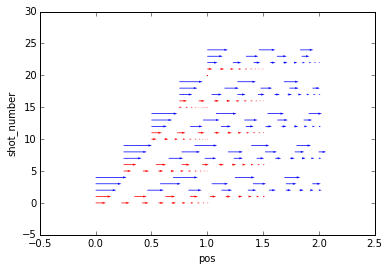

In [14]:
# Plot it
labels = df['label']
axes = df.plot(kind='scatter', x='pos', y='shot_number', c=colormap[labels], s=0)
axes.quiver(df['pos'], df['shot_number'], df['vel'], np.zeros_like(df['vel']), color=colormap[labels], scale_units='xy', angles='xy', scale=2.5, width=.0022)

In [15]:
data_points_1d = df

%store data_points_1d

Stored 'data_points_1d' (DataFrame)
